# **Práctica 2: Visión Artificial y Aprendizaje**

##Introducción:

En esta práctica se nos plantea el problema de crear una inteligencia artificial que sea capaz de reconocer dígitos manuscritos, esta IA deberá ser implementada utilizando el algoritmo adaboost del cual realizaré un analisis más adelante a lo largo de la documentación realizada. 

###Contexto histórico del algoritmo

Boosting está basado en el cuestionamiento planteado por Kearns y Valiant (1988, 1989): ¿Puede un conjunto de clasificadores débiles crear un clasificador robusto?.En 1990 Robert Schapire responde afirmativamente al cuestionamiento de Kearns y Valiant en un artículo, dicha respuesta tuvo repercusiones significativas en el aprendizaje automático y la estadística, esta potente influencia llevó al desarrollo del boosting.

Cuando fue introducido por primera vez, el boosting refería simplemente al problema de convertir un clasificador débil en uno robusto.
Schapire y Freund luego desarrollaron AdaBoost, un algoritmo adaptativo que ganó el prestigioso Premio Gödel.
AdaBoost es el algoritmo más popular y es quizá el más importante históricamente ya que fue la primera formulación de un algoritmo que pudo aprender de a partir de los clasificadores débiles .

###Clasificadores

 Antes de comenzar el código debemos hacernos la pregunta de *¿Qué son los clasificadores?* Lo primero que deberemos saber es que existen dos tipos de clasificadores, **los clasificadores débiles** estan definidos para ser clasificadores los cuales estan solo débilmente correlacionados con la clasificación correcta. Por otro lado encontramos **los clasificadores fuertes** estos poseen un mejor desempeño que los débiles ya que sus clasificaciones al estar formadas por el consenso de muchos debiles son más acertadas

###¿Qué vamos a clasificar?

Como ya hemos explicado en la introducción vamos a utilizar este clasificador para clasificar dígitos manuscritos del 0 al 9, estos dígitos se encuentran en la conocida base de datos MNIST, para ser concretos disponemos de sesenta mil imagenes en escala de grises de los dígitos, estos se encuentran en matrices de 28*28 y etiquetatados en un vector paralelo con el número que representan

##Adaptación de base de datos


Para adaptar nuestra base de datos que contiene los dígitos primero deberemos importarla hacia google colab, para ello correremos el siguiente código

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import os
from keras.datasets import mnist


###Adaptación de conjuntos

Lo primero que debemos hacer para comenzar a trabajar será adaptar los conjuntos de nuestra base de datos, para ello pasaremos las matrices de 28*28 que contienen las imagenes a un vector de 784 posiciones y además al ser adaboost un algoritmo binario deberemos transformar las etiquetas a 1 si pertenece al conjunto que queremos entrenar o -1 si no.

In [ ]:

from random import randrange

#Recibimos Mnist_x que es un conjunto de 60000 imagenes de esta manera transformaremos este vector
#de matrices de 28x28 en un solo vector de 784 elementos, por lo que nos quedará en x un conjunto
#de vectores de 784 elementos y en Y nos quedará un conjunto de elementos donde si Y[i]==0 +1 sino -1
def adaptar_conjuntos(mnist_X, mnist_Y, buscado):
    X = mnist_X.reshape(60000,28*28)
    Y = []
    #print(X.shape)
    for i in mnist_Y:
        if i == buscado:
            Y.append(1)
        else:
            Y.append(-1)    
    return (X,Y)


Como podemos apreciar en el código adjuntado he utilizado las funciones de numpy para redimensionar mi conjunto de las X redimensionando las matrices a vector de 784 posiciones

##Clasificadores débiles

Para generar los clasificadores deberemos pasarle a nuestro "constructor" la dimensión de las imagenes para generar el número aleatorio del pixel que "explorará" dicho clasificador además tendremos su "umbral" para mirar si el clasificador debe mirar por arriba o por debajo de ese valor del pixel.

La siguiente función implementada es la que aplicará el clasificador a una imagen recibida, este comprobará si el pixel que el debe de mirar esta por encima o por debajo dependiendo de su umbral o dirección 

Ahora deberemos encontrar el error que ha cometido dicho clasificador para ello utilizaremos el vector D este vector tendrá los valores de como de dificil es una imagen de clasificar este se irá modificando a medida de que aplicamos clasificadores débiles y estos se equivocan, esta función al final devolverá un valor de la suma de todos los errores cometidos

In [ ]:
from random import randrange
#Pixel
#Umbral
#Dirección +1 o -1
    
# Dimension con la que vamos a trabajar. En nuestro caso 28*28
def generar_clasificador_debil(dimension_datos):
    debil = [0,0,0]
    debil[0] = randrange(dimension_datos) #Posición dentro de la imagen
    debil[1] = randrange(256) #Valor
    #Dirección que debemos de tomar
    if randrange(2) == 1:
        debil[2] = 1
    else:
        debil[2] = -1
    #print(debil)
    return debil 

#Devuelve el valor Booleano después de haber aplicado el clasificador a una imagen
def aplicar_clasificador_debil(clasificador, imagen):
    pixel = clasificador[0]
    umbral = clasificador[1]
    direccion = clasificador[2]
    
    if direccion == 1:
        if imagen[pixel] > umbral:
            return 1
        else:
            return -1
    else:
        if imagen[pixel] <= umbral:
            return 1
        else:
            return -1
    
#Obtener el error de la clasificación de nuestro clasificador
#debe de devolver un float sumar los pesos de las imagenes mal clasificadas
#para ello recorremos los vectores X e Y aplicando el clasificador si acierta bien
#pero si no acierta hay que hacer 1*D[i] sino 0*D[i] luego sumar todos los valores de D
def obtener_error(clasificador, X, Y, D):
    resultError = 0
    for i in range(len(X)):
        if aplicar_clasificador_debil(clasificador, X[i]) != Y[i]:
            resultError += D[i]
    return resultError
    
    

##Adaboost


Para comprender el algortimo de adaboost lo que realizaré será una comparación del pseudocódigo que hemos estudiado a lo largo de la práctica y el código que he implementado


###Incialización
En la inicialización de nuestro código recibiremos 4 parámetros a contraposición del pseudocódigo que solo recibiremos 2, el primer parámetro X será el conjunto de imagenes con el que entrenaremos a nuestro Adaboost, estas ya se encuentran normalizadas a modo de vector, el parámetro Y es las etiquetas correspondientes a cada imagen, tendremos también el parámtro T el cual especificará cuantos de los mejores clasificadores débiles nos quedaremos y el A es la cantidad de pruebas aleatórias que generaremos.

Después inicializaremos los vectores donde almacenaremos los errores de nuestros clasificadores y inicializaremos el vector de D's donde almacenaremos la dificultap de clasificación de cada imagen.

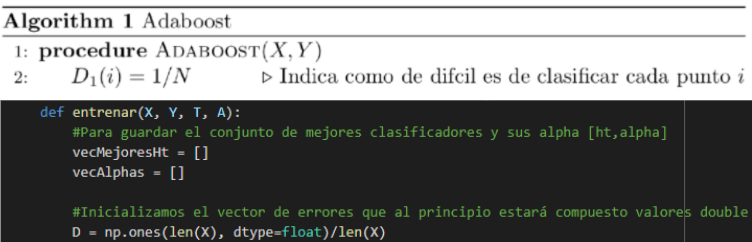

###Creación y selección
Ahora comenzaremos a crear clasificadores débiles y seleccionaremos el que menor error tenga de todos ellos para almacenarlo en nuestro vector de mejores clasificadores, esta comparación de errores la realizaremos aplicando el clasificador a cada una de las fotos del conjunto de entrenamiento.

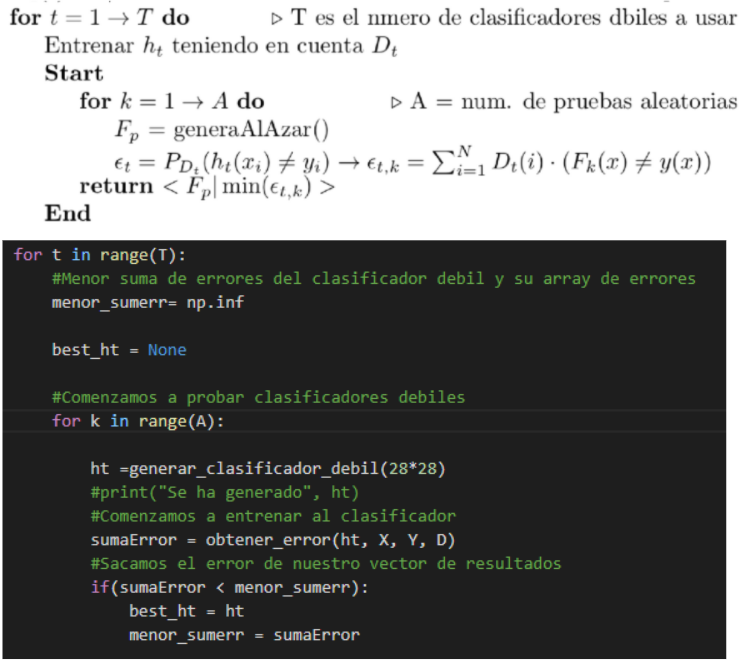

###Cálculo de confianza
Este cálculo se realizará aplicando la fórmula del pseudocódigo, esta se ha aplicado utilizando las funciones de numpy para generar el logoritmo neperiano y para transformarlo a un float de 64bits y meteremos nuestro clasificador con su respectiva confianza en los vectores correspondientes

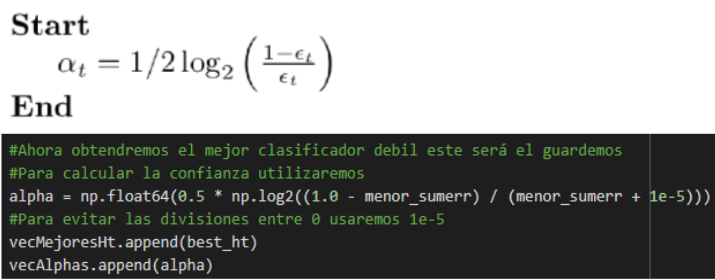

###Actualización de dificultades
Ahora actualizaremos las dificultades de clasificación de nuestras imagenes de entrenamiento para ello seguiremos la siguiente formula, esta no ha sido implementada con numpy, recordemos que para aplicar esta formula deberemos aplicar el mejor clasificador débil y obtendremos 1 o -1 después una vez recalculados los valores ya habremos acabado el algoritmo y podremos devolver los mejores clasificadores y sus confianzas

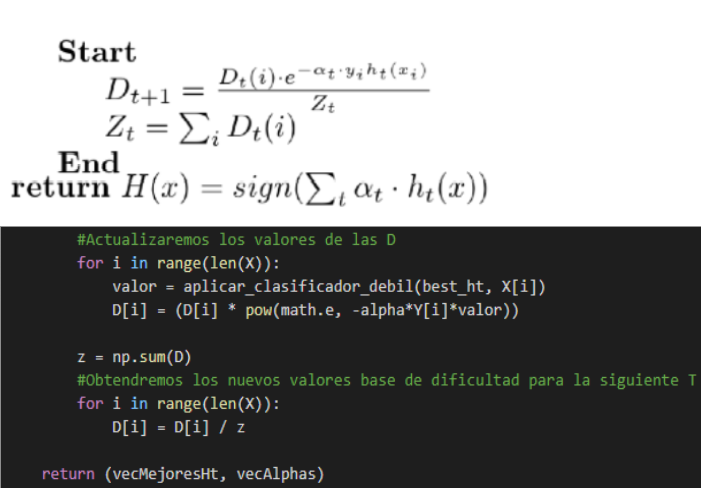

###Código implementado

In [ ]:

import numpy as np
import math

#X vector de imagenes ya transformado
#Y vector de etiquetas transformado
#T número de veces que se ejecuta el bucle
#A cantidad de clasificadores debiles que se generan en cada bucle
#D es una array de valores inicializado a 1/cantidadImagenes
def entrenar(X, Y, T, A):
    #Para guardar el conjunto de mejores clasificadores y sus alpha [ht,alpha]
    vecMejoresHt = []
    vecAlphas = []
    
    #Inicializamos el vector de errores que al principio estará compuesto valores double
    D = np.ones(len(X), dtype=float)/len(X)
    
    for t in range(T):
        #Menor suma de errores del clasificador debil y su array de errores
        menor_sumerr= np.inf
        
        best_ht = None
        
        #Comenzamos a probar clasificadores debiles
        for k in range(A):
            
            ht =generar_clasificador_debil(28*28)
            #print("Se ha generado", ht)
            #Comenzamos a entrenar al clasificador
            sumaError = obtener_error(ht, X, Y, D)
            #Sacamos el error de nuestro vector de resultados
            if(sumaError < menor_sumerr):
                best_ht = ht
                menor_sumerr = sumaError
            
        #Ahora obtendremos el mejor clasificador debil este será el guardemos    
        #Para calcular la confianza utilizaremos
        alpha = np.float64(0.5 * np.log2((1.0 - menor_sumerr) / (menor_sumerr + 1e-5)))
        #Para evitar las divisiones entre 0 usaremos 1e-5
        vecMejoresHt.append(best_ht)
        vecAlphas.append(alpha)
        #Actualizaremos los valores de las D
        for i in range(len(X)):
            valor = aplicar_clasificador_debil(best_ht, X[i])
            D[i] = (D[i] * pow(math.e, -alpha*Y[i]*valor))
                    
        z = np.sum(D)
        #Obtendremos los nuevos valores base de dificultad para la siguiente T
        for i in range(len(X)):
            D[i] = D[i] / z

    return (vecMejoresHt, vecAlphas)


##Generador de conjuntos


###Conjuntos de Entrenamiento
Esta función se encargará de crear los conjutos que entrenarán a nuestro adaboos de manera que los entrenamiento se realizarán con la mitad del vector con etiquetas y fotos del clasificador que estamos entrenando y la otra mitad con valores aleatorios

In [ ]:
#lp ->cantidad imagenes que queremos
#X ->conjunto adaptado x
#y ->conjunto adaptado y
def generadorConjuntosEntrenamiento(lp,X,Y):
    pruebasZerosX = []
    pruebasZerosY = []
    for x,y in zip(X, Y):
        if len(pruebasZerosX) <= lp/2:
            if y == 1:
                pruebasZerosX.append(x)
                pruebasZerosY.append(y)
        else:
            if len(pruebasZerosX)!= lp and len(pruebasZerosX) > lp/2:
                pruebasZerosX.append(x)
                pruebasZerosY.append(y)
    #print(pruebasZerosY)
    return (pruebasZerosX,pruebasZerosY)

###Conjuntos de Test
Este generador de conjuntos se encargará de generar los conjuntos con los que testearemos nuestros clasificadores, de manera que escogeremos imagenes aleatorios del conjunto adaptado de mnist para comprobar su funcionamiento y sacar un porcentaje de aciertos que luego usaremos más adelante

In [ ]:
#lp ->cantidad imagenes que queremos
#X ->conjunto adaptado x
#y ->conjunto adaptado y
def generadorConjuntosTest(lp,X,Y):
    conjuntoTestX = []
    conjuntoTestY = []

    for i in range(lp):
      imgIndex = randrange(60000)
      conjuntoTestX.append(X[imgIndex])
      conjuntoTestY.append(Y[imgIndex])
    
    return (conjuntoTestX,conjuntoTestY)


Esta división se realiza para que nuestro Adaboost no se "aprenda" las imagenes de entrenamiento y arroje unos valores de porcentaje de acierto de casi el 100% al pasarle las mismas para sacar el porcentaje de acierto que más tarde usaríamos para la reclamación de imagenes por los clasificadores

##Aplicar clasificador fuerte
En esta función aplicaremos todos los clasificadores débiles que componen un clasificador fuerte a una imagen de tal manera que devolveremos las "predicciones" que tienen sobre esa imagen.

In [ ]:
#H ->Conjunto de clasificadores débiles con sus respectivas alphas
#X ->Imagen a la que aplicaremos dicho clasificador
def aplicar_clasificador_fuerte(H,X):
    hts,alphas = H
    certeza = 0
    resultados = 0
    
    for ht,alpha in zip(hts,alphas):
        resultados += (aplicar_clasificador_debil(ht,X) * alpha)
    
    return resultados

##Obtener porcentaje de aciertos
Una vez sacadas las predicciones del clasificador fuerte sobre una imagen de tal manera que si coinciden en signo la predicción del clasificador y la etiqueta de la Y sumaremos un acierto para el clasificador

In [ ]:
#X ->Conjunto de imagenes adaptadas
#Y ->Conjunto de etiquetas adaptadas
#c_f ->Clasificador fuerte del que vamos a sacar el % de acierto
def sacarPorcentaje(X,Y,c_f):
    predicciones = []
    aciertos = 0.0
    totalsuma = 0
    for x in X:
        predicciones.append(aplicar_clasificador_fuerte(c_f,x))
    #print(predicciones)
    for p,y in zip(predicciones, Y):
        totalsuma+=p
        if (p > 0) and (y > 0):
            aciertos += 1
        elif (p < 0) and (y < 0):
            aciertos += 1
    #print(totalsuma)
    return (aciertos/len(Y)*100, totalsuma)

##Adaptación para todos los números
Como ya sabemos Adaboost produce una salida binaria, de tal manera mi adaptación para poder clasificar dígitos del 0 al 9 ha sido la siguiente:
Mediante un bucle for de 0 a 9 generaremos los conjuntos adaptados para cada número con las funcioes previamente explicadas, acto seguido generaremos sus conjuntos de entrenamiento y testeo, después sacaremos los porcentajes de acierto para los conjuntos de testeo y guardaremos los clasificadores fuertes generados y sus porcentajes en dos vectores que luego devolveremos

In [ ]:
#mnist_X ->conjunto de mnist sin adaptar
#mnist_Y ->conjunto de etiquetas sin adaptar de mnist
#T -> cantidad de T que queremos que genere nuesto Adaboost
#A -> cantidad de A que queremos que genere nuestro Adaboost
def total(mnist_X,mnist_Y,T,A,cantEntreno,cantTesteo):
    clasificadoresFuertes = []
    porcentajes=[]
    for i in range(10):
        #print("Adaptando conjuntos para: ",i)
        (X, Y) = adaptar_conjuntos(mnist_X, mnist_Y, i)
        #print("Generando conjuntos de entreno para: ", i)
        (XEntrenar, YEntrenar) = generadorConjuntosEntrenamiento(cantEntreno,X, Y)
        #print("Entrenando a :", i)
        cf=entrenar(XEntrenar,YEntrenar,T,A)
        #print("Generando conjuntos de Testeo para:",i)
        (XTestear, YTestear) = generadorConjuntosTest(cantTesteo, X, Y)
        (porcentaje, valor)=sacarPorcentaje(XTestear, YTestear, cf)
        porcentajes.append(porcentaje)
        #print("Porcentaje aciertos para ", i , ":" , porcentaje,"%")
        clasificadoresFuertes.append(cf)

    #print(len(clasificadoresFuertes))    
    return(clasificadoresFuertes,porcentajes)

##Reclamador de imagenes
Esta funcion aplicará todos los clasificadores fuertes que hemos entrenado a una imagen del conjunto mnist de tal manera que mediante sus signos sabremos si ese clasificador ya sea 0,1,2 etc, ha reclamado la imagen como suya, ya que no estamos en situaciones ideales, puede darse el caso de que uno más clasificadores reclamen la imagen como suya, de este manera si esto ocurre le adjudicaremos la imagen al clasificador que mayor porcentaje de acierto tenga, también puede darse el caso de que ninguno de los clasificadores reclame la imagen como suya, de esta manera le adjudicaremos la imagen a aquel clasificador que menor porcentaje de acierto tenga

In [ ]:
#imagen-> imagen a procesar
#etiqueta-> etiqueta de la imagen
#cfs-> clasificadores fuertes
#porcentajes-> porcentajes de acierto de cada clasificador fuerte
def esNumeroClase(imagen,etiqueta,cfs,porcentajes):
  #print(porcentajes)
  #print("El número pasado es:",etiqueta)
  mejor = 0
  es = []

  for u in range(len(cfs)):
    resultados = []
    hts,alphas = cfs[u]
    if 0 < aplicar_clasificador_fuerte(cfs[u],imagen):
      #print("Es un ", u)
      es.append(u)
    #else:
      #print("No es un:", u)
  
  porcentajesPuede = []
  if len(es) == 0:#Caso de que ningun clasificador reconozca la imagen como suya
    mejor=np.inf
    porcentajesPuede=porcentajes
    for m in porcentajesPuede:
      if mejor > m:
        mejor = m
  else:
    for i in es:
      porcentajesPuede.append(porcentajes[i])

    for m in porcentajesPuede:
      if mejor < m:
        mejor = m
  
  for k in range(len(porcentajes)):
    if porcentajes[k] == mejor:
      valor = k
  
  if valor == etiqueta:
    return 1
  else:
    return 0

##Estudio de T, A e Imagenes de entrenamiento
Como podemos apreciar en la siguiente gráfica existe una gran coorelación entre la cantidad de T generadas en el Adaboost y el porcentaje de acierto,aumentando este % a mayor cantidad T's pero estabilizandose entorno al 90% una vez superadas las 60 T's, esta gráfica solo ha sido aplicada al número 0

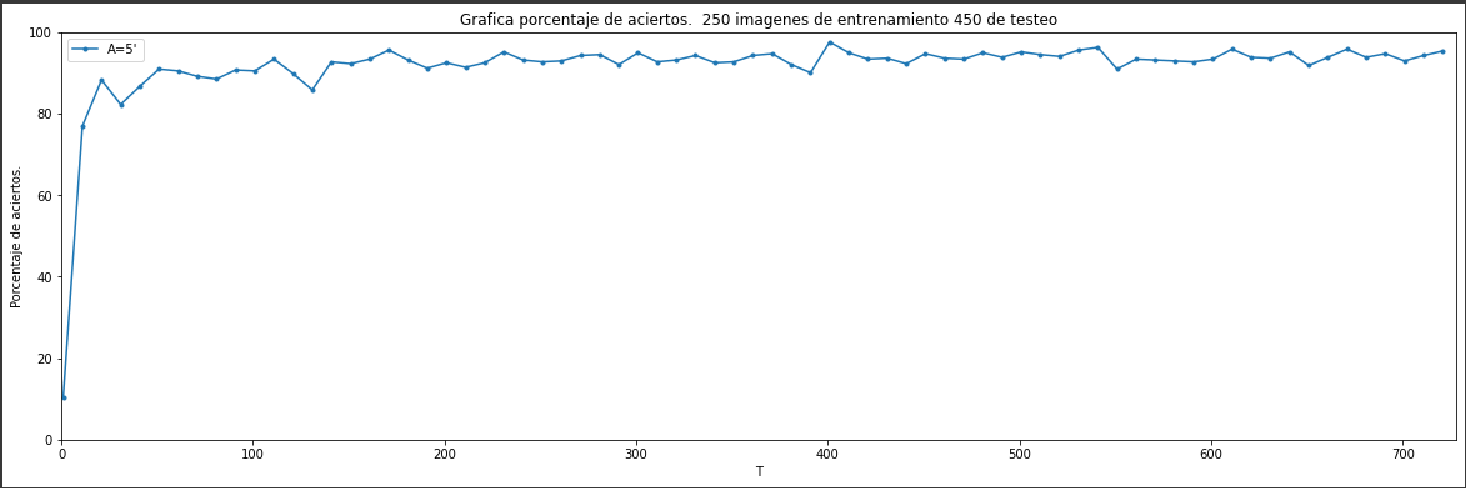

En cuanto a la coorrelación de la cantidad de A's generadas y el porcentaje de acierto de nuestro Adaboost podemos deducir que al igual que con las T's a mayor cantidad de estas mayor será el porcentaje de acierto, como podemos apreciar en nuestra gráfica el porcentaje de acierto empieza a estabilizarese en cuando pasamos de las 20 A's generadas.

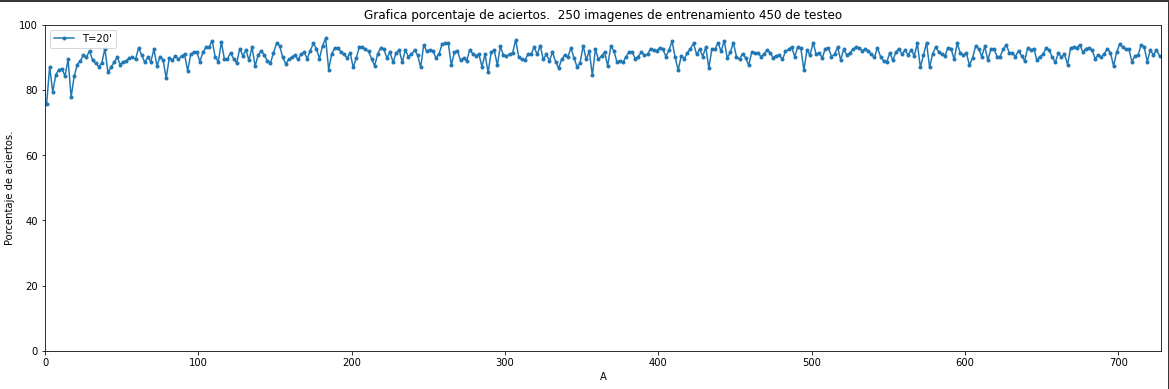

En cuanto a la cantidad de imagenes de entrenamiento podemos visualizar en la siguiente gráfica que el porcentaje de acierto novaría mucho al pasar de las 40 imagenes de entrenamiento, por lo que podemos deducir que más de 40 imagenes es un mal gasto de computo para los clasificadores

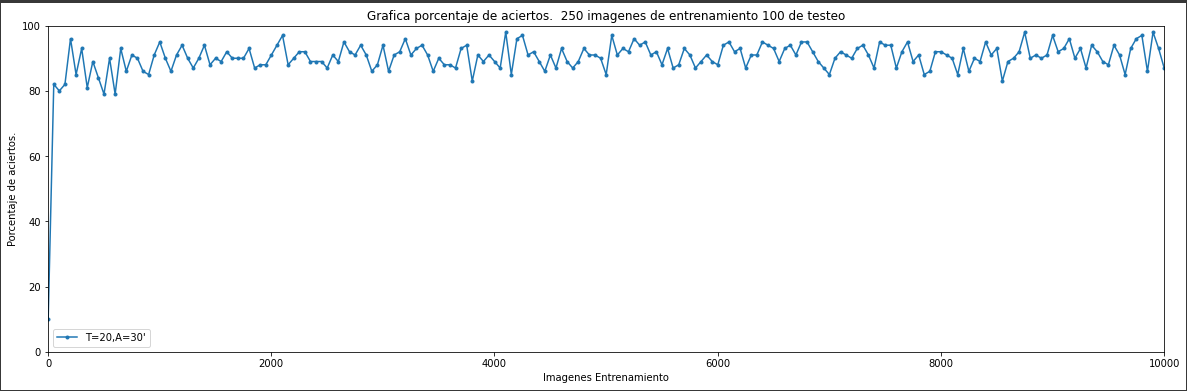

En la siguiente gráfica podemos visualaizar como como aumenta y disminuye el porcentaje de acierto a medida que incrementamos los valores habiendo valores del 100% de acierto cuando disponemos de pocas imagenes de testeo y entrenamiento acertando estas por azar, esta gráfica nos deja ver la gran variabilidad en los acierto y errores de Adaboost cuando cuenta con pocas A, T y imagenes de entrenamiento y testeo

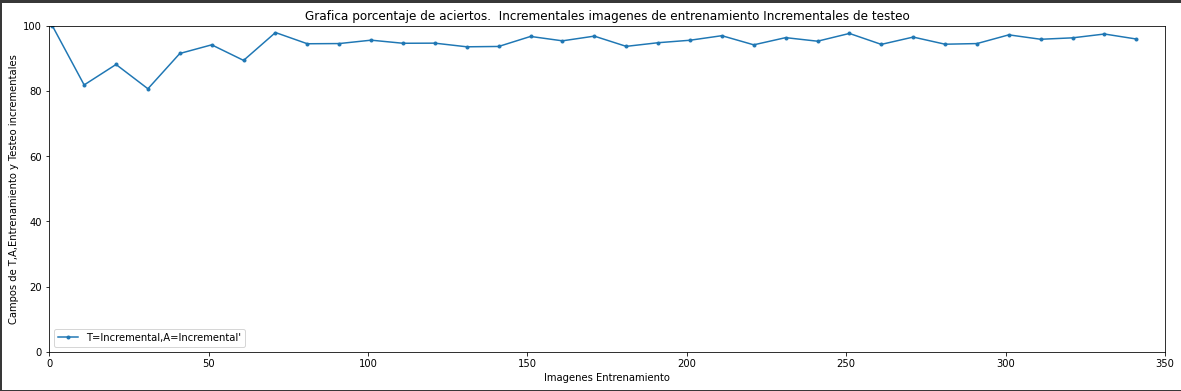

Como podemos observar en las gráficas en ninguna se produce un sobreentrenamiento ya sea por la cantidad de T's,A's o imagenes de entrenamiento pasadas a nuestro Adaboost, el porque de esto es que Adaboost se regula por si solo en el recálculo de las D

La siguiente gráfica muestra el incremento del tiempo de ejecución de entrenamiento en función de la cantidad de T's generadas

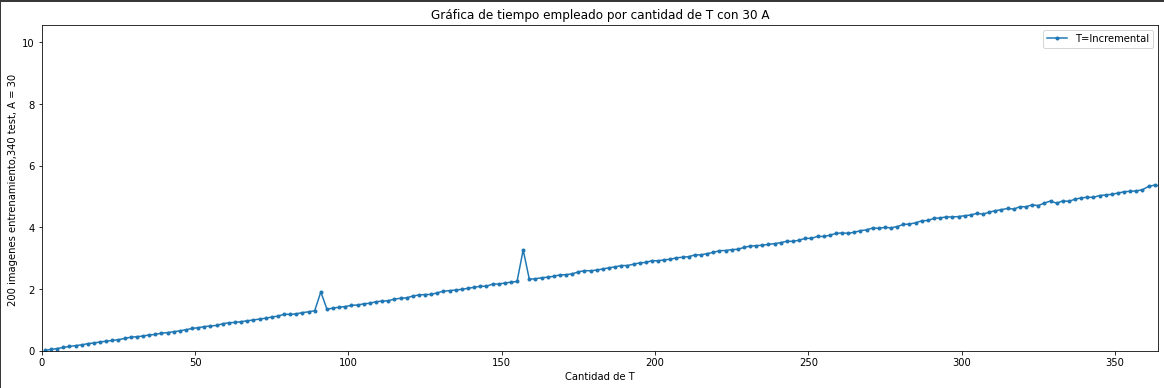

En la siguiente gráfica podemos observar el porcentaje de aciertos para todos los números del conjunto, como podemos apreciar el porcentaje de acierto nunca es superior al 70% independientemente de el número de imagenes de entrenamiento, el conjunto de testeo, la cantidad de T's o A's 


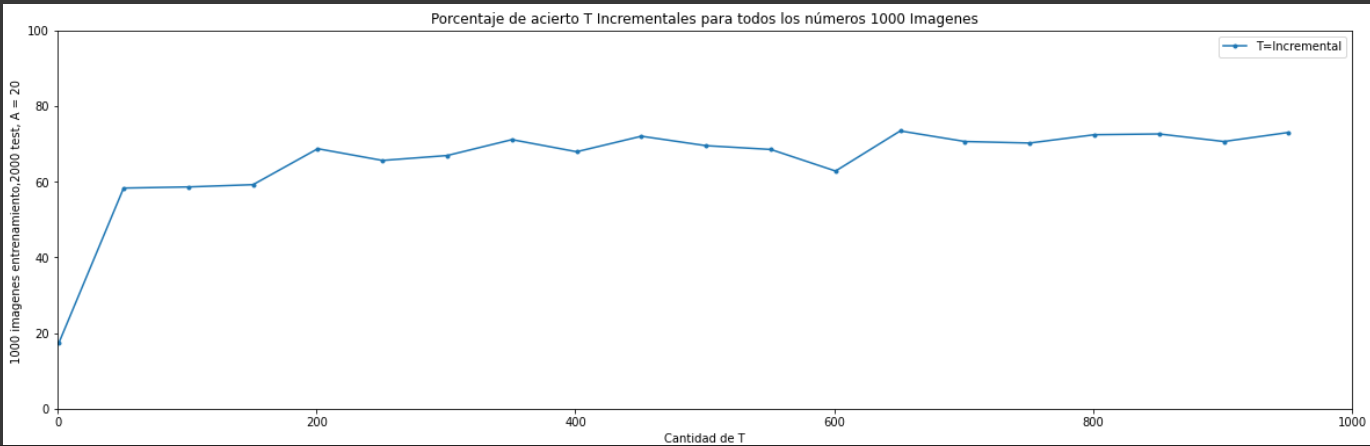

##Código Main para comprobaciones
En el siguiente código main podemos ver un resumen de todo lo implementado anteriormente si desea probarlo puede ir variando los valores de la llamada a la función total, además si quiere sacar el porcentaje de acierto para más imagenes puede modificar la variable cantP para modificar la cantidad con las que probaremos nuestro adaboost completo

In [ ]:
# Importamos las librerias que necesitaremos
import numpy as np
import matplotlib.pyplot as plt

# Cargamos la base de datos
(mnist_X, mnist_Y), (x_test, y_test) = mnist.load_data()
mnist_X,  mnist_Y.shape

# Adaptar los conjuntos X e Y a AdaBoost
(XS, YS) = adaptar_conjuntos(mnist_X, mnist_Y, 0)

#Sacamos todos los clasificadores y porcentajes
T = 50
A = 30
cantTrain = 3000
cantPorc = 4000
(clasificadoresEntrenados,porcentajesAcierto)=total(mnist_X, mnist_Y, T, A, cantTrain, cantPorc)

#Los aplicamos a 10 imagenes al azar
PorcentajeTotalImagenes = 0
cantP = 1000
for i in range(cantP):
  imgIndex = randrange(60000)
  PorcentajeTotalImagenes += esNumeroClase(XS[imgIndex],mnist_Y[imgIndex],clasificadoresEntrenados,porcentajesAcierto)
print((PorcentajeTotalImagenes/cantP)*100)


##Anexo

###Ejemplo de código utilizado para las gráficas de acierto y coste temporal

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import time


(mnist_X, mnist_Y), (x_test, y_test) = mnist.load_data()
mnist_X,  mnist_Y.shape
# Adaptar los conjuntos X e Y a AdaBoost
i = 1
vecT = []
vecPr = []
(X, Y) = adaptar_conjuntos(mnist_X, mnist_Y, 0)
(XS, YS) = adaptar_conjuntos(mnist_X, mnist_Y, 0)
while i < 1000:
  #Sacamos todos los clasificadores y porcentajes
  T = i
  A = 20
  cantTrain = 1000
  cantPorc = 2000
  print("Para T = ", i)
  (clasificadoresEntrenados,porcentajesAcierto)=total(mnist_X, mnist_Y, T, A, cantTrain, cantPorc)
  #Los aplicamos a 10 imagenes al azar
  PorcentajeTotalImagenes = 0
  cantP = 1000
  for h in range(cantP):
    imgIndex = randrange(60000)
    PorcentajeTotalImagenes += esNumeroClase(XS[imgIndex],mnist_Y[imgIndex],clasificadoresEntrenados,porcentajesAcierto)
  print((PorcentajeTotalImagenes/cantP)*100)

  vecPr.append((PorcentajeTotalImagenes/cantP)*100)
  vecT.append(i)
  i = i + 50

plt.figure(figsize=(20, 6))
plt.plot(vecT,vecPr, marker=".",label="T=Incremental")
plt.xlim(0,1000)
plt.ylim(0,100)
plt.xlabel("Cantidad de T")
plt.ylabel("1000 imagenes entrenamiento,2000 test, A = 20 ")
plt.title("Porcentaje de acierto T Incrementales para todos los números 1000 Imagenes")
plt.legend()
plt.show()